In [1]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import xarray            as xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import netCDF4
import yaml
import sys
import os

from   pylab             import cm
from   scipy             import ndimage

NaN = np.nan
import warnings
warnings.filterwarnings("ignore")

# FUNCTIONS

In [2]:
################################
### Single map plot function ###
################################

def make_map(ncfile, pngfile, data, cmap, vext, title,showcolorbar=True):
    dpi = 150

    # Get lat, lon and cartopy_projection_object
    ds  = xr.open_dataset(ncfile)
    lat = ds.lat.values
    lon = ds.lon.values
    m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude,
                           ds.rotated_pole.grid_north_pole_latitude)

    # Domain limites
    xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

    # Creating figure
    fig = plt.figure()
    fig.set_dpi(dpi)
    ax = plt.axes(projection=m)
    pc = ax.pcolormesh(lon, lat, data, cmap=cmap,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree())
    vext[0], vext[1] = pc.get_clim() # Useful when input was vext[0]=None and/or vext[1]=None  
 
    # Domain limites
    xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
    ax.set_extent([xll, xur, yll, yur], crs=m)

    # Coastlines + political borders
    ax.coastlines()
    L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
    ax.add_feature(L0_country_ALL, edgecolor='black')

    # Title
    plt.title(title, fontsize=8)

    # Colorbar
    if showcolorbar == True:
        
        if   vext[0] ==  -vext[1]: extend = 'both'
        else                     : extend = 'neither'
        sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vext[0],vext[1]))
        sm._A = []
        plt.colorbar(sm,ax=ax, extend=extend)

    # Saving figure
    plt.savefig(pngfile,bbox_inches='tight', dpi=dpi)
    
    plt.close()

# MAIN

In [17]:
#########################################################################
# Input arguments                                                       #
#########################################################################

working_directory =     '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
YYYYi             =     int(2014)
YYYYf             =     int(2015)
period            =     'annual'
dataset           =     'MYD06_L2'
layerdef_MODIS    =     'Cloud_Top_Pressure'
layerdef_CALIPSO  =     'pmax'
window            =     int(1)
overwrite         =     'false'.lower()

#########################################################################
# Hardcoded values                                                      #
#########################################################################
if   period == 'annual': MMs = [1,2,3,4,5,6,7,8,9,10,11,12]
elif period == 'DJF'   : MMs = [ 1, 2,12]
elif period == 'MAM'   : MMs = [ 3, 4, 5]
elif period == 'JJA'   : MMs = [ 6, 7, 8]
elif period == 'SON'   : MMs = [ 9,10,11]
else                   : MMs = [ int(period) ] # single month

#########################################################################
# Configuration file (yml)                                              #
#########################################################################
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

domain     = config['domain'        ]
dir_NetCDF = config['CALIPSOvsMODIS']['NetCDF'] + '/CALIPSO_' + layerdef_CALIPSO + '_' + dataset + '_' + layerdef_MODIS  + '/' + domain
dir_png    = config['CALIPSOvsMODIS']['png'   ] + '/CALIPSO_' + layerdef_CALIPSO + '_' + dataset + '_' + layerdef_MODIS  + '/' + domain + '/%03d' % (window) 

if not os.path.exists(dir_png): os.makedirs(dir_png)

#########################################################################
# Main part                                                             #
#########################################################################

# Summing data (value and n for each level) from all the selected months
data_sum = {}
for YYYY in range(YYYYi,YYYYf+1):
    for MM in MMs:
        ncfile = '%s/%4d%02d.nc' % (dir_NetCDF,YYYY,MM)
        ds     = xr.open_dataset(ncfile)
        for varname in ds.keys():
            if 'cloud_cover' in varname:
                if varname not in data_sum: data_sum[varname]  = ds[varname].values
                else                      : data_sum[varname] += ds[varname].values

# Making individual plot to save

In [6]:
# Making plot of the averaged values (temporal + spatial)
for varname in ['Tot_cloud_cover', 'High_cloud_cover', 'Mid_cloud_cover', 'Low_cloud_cover' ]:
    
    varname_cloudcover_MODIS   = varname + '_sum_MODIS'
    varname_cloudcover_CALIPSO = varname + '_sum_CALIPSO'
    varname_n                  = varname + '_n'

    'Computing temoral mean: at this point we still to have only tracks'
    data_temporal_mean_MODIS   = data_sum[varname_cloudcover_MODIS  ] / data_sum[varname_n]
    data_temporal_mean_CALIPSO = data_sum[varname_cloudcover_CALIPSO] / data_sum[varname_n]
    
    'Computing spatial mean over a square of size window x window'
    data_spatial_mean_MODIS   = ndimage.generic_filter(data_temporal_mean_MODIS  , np.nanmean, size=window, mode='constant',cval=np.nan)
    data_spatial_mean_CALIPSO = ndimage.generic_filter(data_temporal_mean_CALIPSO, np.nanmean, size=window, mode='constant',cval=np.nan) 
    data_spatial_mean_DIFF    = data_spatial_mean_MODIS - data_spatial_mean_CALIPSO

    title_MODIS   = '%s %s\n%s %d-%d' % ('MODIS'        , varname, period, YYYYi, YYYYf)
    title_CALIPSO = '%s %s\n%s %d-%d' % ('CALIPSO'      , varname, period, YYYYi, YYYYf)
    title_DIFF    = '%s %s\n%s %d-%d' % ('MODIS-CALIPSO', varname, period, YYYYi, YYYYf)

    pngfile_MODIS   = '%s/%s_%s_%d-%d_%s.png' % (dir_png,'MODIS'        ,  varname, YYYYi, YYYYf, period)
    pngfile_CALIPSO = '%s/%s_%s_%d-%d_%s.png' % (dir_png,'CALIPSO'      ,  varname, YYYYi, YYYYf, period)
    pngfile_DIFF    = '%s/%s_%s_%d-%d_%s.png' % (dir_png,'MODIS-CALIPSO',  varname, YYYYi, YYYYf, period)

    #make_map(ncfile, pngfile_MODIS  , data_spatial_mean_MODIS  , cmapv, [ 0.00,1.00], title_MODIS  )
    #make_map(ncfile, pngfile_CALIPSO, data_spatial_mean_CALIPSO, cmapv, [ 0.00,1.00], title_CALIPSO)
    #make_map(ncfile, pngfile_DIFF   , data_spatial_mean_DIFF   , cmapd, [-0.55,0.55], title_DIFF   )
    print(pngfile_MODIS)

    plt.show()

/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/CALIPSOvsMODIS/png/CALIPSO_pmax_MYD06_L2_Cloud_Top_Pressure/NAM11/029/MODIS_Tot_cloud_cover_2014-2015_1.png
/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/CALIPSOvsMODIS/png/CALIPSO_pmax_MYD06_L2_Cloud_Top_Pressure/NAM11/029/MODIS_High_cloud_cover_2014-2015_1.png
/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/CALIPSOvsMODIS/png/CALIPSO_pmax_MYD06_L2_Cloud_Top_Pressure/NAM11/029/MODIS_Mid_cloud_cover_2014-2015_1.png
/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/CALIPSOvsMODIS/png/CALIPSO_pmax_MYD06_L2_Cloud_Top_Pressure/NAM11/029/MODIS_Low_cloud_cover_2014-2015_1.png


# DATA MATRICES

In [18]:
data_MODIS   = []
data_CALIPSO = []
data_DIFF    = []

for varname in ['Tot_cloud_cover', 'High_cloud_cover', 'Mid_cloud_cover', 'Low_cloud_cover' ]:
    
    varname_cloudcover_MODIS   = varname + '_sum_MODIS'
    varname_cloudcover_CALIPSO = varname + '_sum_CALIPSO'
    varname_n                  = varname + '_n'
    
    'Computing temoral mean: at this point we still to have only tracks'
    data_temporal_mean_MODIS   = data_sum[varname_cloudcover_MODIS  ] / data_sum[varname_n]
    data_temporal_mean_CALIPSO = data_sum[varname_cloudcover_CALIPSO] / data_sum[varname_n]
    
    'Computing spatial mean over a square of size window x window'
    data_spatial_mean_MODIS   = ndimage.generic_filter(data_temporal_mean_MODIS  , np.nanmean, size=window, mode='constant',cval=np.nan)
    data_spatial_mean_CALIPSO = ndimage.generic_filter(data_temporal_mean_CALIPSO, np.nanmean, size=window, mode='constant',cval=np.nan) 
    data_spatial_mean_DIFF    = np.subtract(data_spatial_mean_MODIS,data_spatial_mean_CALIPSO)

    data_MODIS.append(  data_spatial_mean_MODIS)
    data_CALIPSO.append(data_spatial_mean_CALIPSO)
    data_DIFF.append(   data_spatial_mean_DIFF)

# SANITARY CHECK

In [20]:
data_MODIS_t   = data_MODIS[0]
data_MODIS_HML = np.add(data_MODIS[1], data_MODIS[2], data_MODIS[3])
print(data_MODIS_t)
print('\n#########################################################################\n')
print(data_MODIS_HML)
check = np.subtract(data_MODIS_t,data_MODIS_HML)
if    np.nanmean(check) != 0: print('Sanitary Check Failed : ',np.nanmean(check))
elif  np.nanmean(check) == 0: print('Sanitary Check Successful')


[[0.7064663  0.70932686 0.70932686 ... 0.60284007 0.6026068  0.61068344]
 [0.7041778  0.7086608  0.7092823  ... 0.60109824 0.6007386  0.60769916]
 [0.70170337 0.7041579  0.70228505 ... 0.6011928  0.6008704  0.6072455 ]
 ...
 [0.5033408  0.5040329  0.49945354 ... 0.9088537  0.9043624  0.9008361 ]
 [0.49762923 0.49870473 0.4942727  ... 0.9041338  0.8999592  0.8969782 ]
 [0.49711472 0.4972073  0.48883334 ... 0.90053844 0.89696383 0.8936133 ]]

#########################################################################

[[0.6711122  0.66979444 0.66979444 ... 0.5019182  0.49125615 0.49235755]
 [0.6660367  0.6623137  0.65830827 ... 0.50342953 0.49393666 0.49499452]
 [0.6599983  0.6529349  0.6486312  ... 0.50512964 0.4964179  0.49747026]
 ...
 [0.45373735 0.4559583  0.4540721  ... 0.81786    0.81756926 0.8021587 ]
 [0.44500458 0.44783962 0.4463727  ... 0.81545055 0.81199515 0.7964823 ]
 [0.44310364 0.4465078  0.43922418 ... 0.82285345 0.8188021  0.8031304 ]]
Sanitary Check Failed :  0.1595447


# BIAS

In [21]:
## BIAS ##
print('Bias Total cloud cover : ',np.nanmean(data_DIFF[0])*100)
print('Bias High cloud cover  : ',np.nanmean(data_DIFF[1])*100)
print('Bias Mid cloud cover   : ',np.nanmean(data_DIFF[2])*100)
print('Bias Low cloud cover   : ',np.nanmean(data_DIFF[3])*100)

print('Mean bias HML : ', np.mean([np.nanmean(data_DIFF[1])*100,np.nanmean(data_DIFF[2])*100,np.nanmean(data_DIFF[3])*100]))

Bias Total cloud cover :  -5.0388917326927185
Bias High cloud cover  :  -13.946224749088287
Bias Mid cloud cover   :  -1.916099339723587
Bias Low cloud cover   :  6.527999043464661
Mean bias HML :  -3.1114416817824044


# SETTING THE GRID 

In [4]:
dpi      = 150
data_dir = 'pampa/poitras/DATA'
gemname  = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"
step_0   = gemname + "_step0"

# Step 0 GEM path to set lat and lon in cartopy
ncfile = '/{}/GEM5/{}/Samples_NetCDF/{}/pm2013010100_00000000p.nc'.format(data_dir,gemname,step_0)

# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

# MULTI PLOT

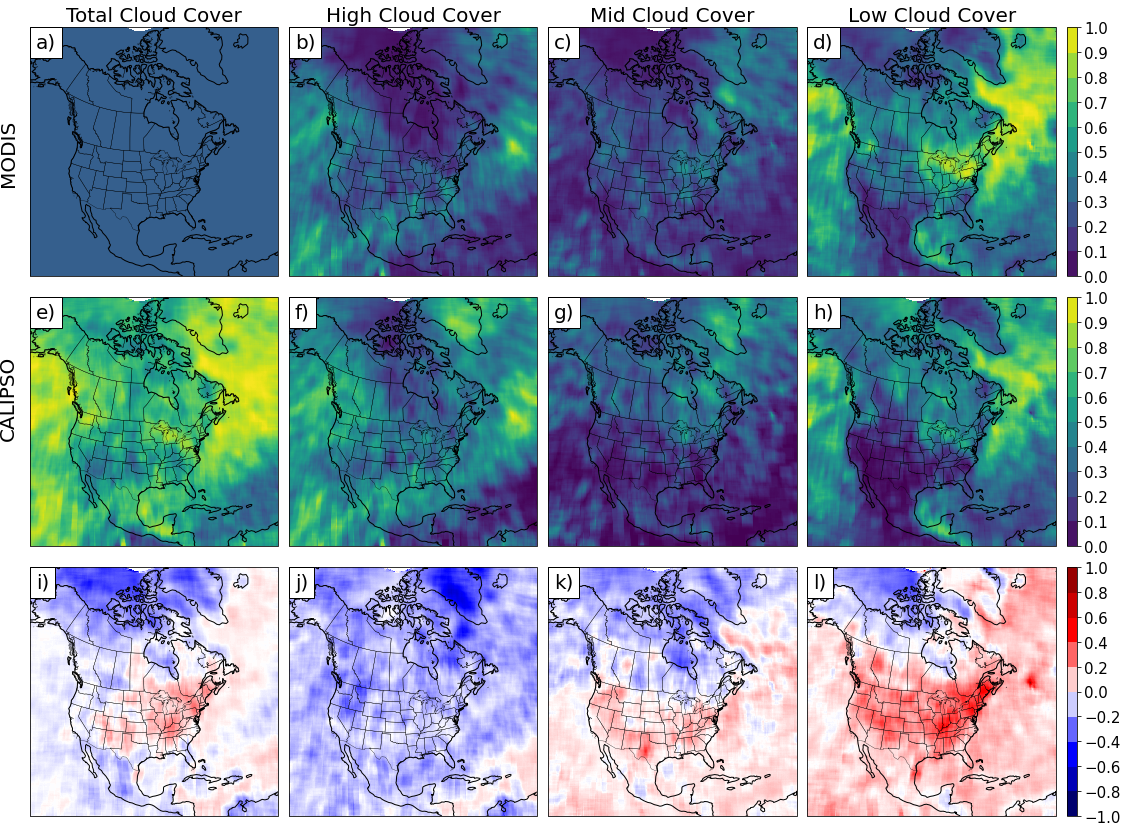

In [8]:
lon_list = lon[0].tolist()
central_longitude = (lon_list[int(round(len(lon[0])/2,0))] + lon_list[int(round(len(lon[0])/2,0)) - 1])/2

fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext = [0,1]
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
cmap_diff     = plt.cm.seismic                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
cmaplist_diff = [cmap_diff(i) for i in range(cmap_diff.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
c             = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_diff, cmap_diff.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###
bounds_diff  = np.linspace(-1, 1, 11)                                                                  ###
                                                                                                       ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N)                                       ###
norm_diff    = mpl.colors.BoundaryNorm(bounds_diff, cmap_diff.N)                                       ###
##########################################################################################################

L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
#############################
###        MODIS          ###
#############################

###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
#cm = 'viridis'       # Color for maps                                  ###
#c  = 'seismic'       # Color for difference                            ###
###########################################################################
# First subplot
ax1 = plt.axes([l1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total Cloud Cover', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
MODIS_t = ax1.pcolormesh(lon, lat,data_MODIS[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Second subplot
ax2 = plt.axes([l2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High Cloud Cover', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,data_MODIS[1] , cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Third subplot
ax3 = plt.axes([l3, b, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid Cloud Cover', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,data_MODIS[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Fourth subplot
ax4 = plt.axes([l4, b, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low Cloud Cover', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,data_MODIS[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

###########################
###       CALIPSO       ###
###########################
b = 0.48
# First subplot
ax5 = plt.axes([l1, b, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
#ax5.set_title('Total Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
CALIPSO_t = ax5.pcolormesh(lon, lat,data_CALIPSO[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Second subplot
ax6 = plt.axes([l2, b, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
#ax6.set_title('High Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,data_CALIPSO[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Third subplot
ax7 = plt.axes([l3, b, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
#ax7.set_title('Mid Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,data_CALIPSO[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

# Fourth subplot
ax8 = plt.axes([l4, b, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
#ax8.set_title('Low Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,data_CALIPSO[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

###########################
###        COSP         ###
###########################
b = 0.23

vext_diff = [-1,1]
norm_diff = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
# First subplot
ax9 = plt.axes([l1, b, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
#ax9.set_title('Total Cloud Cover \n MODIS - CALIPSO',fontsize = 15)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
DIFF_t = ax9.pcolormesh(lon, lat,data_DIFF[0], cmap=c,vmin=vext_diff[0], vmax=vext_diff[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Second subplot
ax10 = plt.axes([l2, b, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
#ax10.set_title('High Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat,data_DIFF[1], cmap=c,vmin=vext_diff[0], vmax=vext_diff[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Third subplot
ax11 = plt.axes([l3, b, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
#ax11.set_title('Mid Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat,data_DIFF[2], cmap=c,vmin=vext_diff[0], vmax=vext_diff[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Fourth subplot
ax12 = plt.axes([l4, b, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
#ax12.set_title('Low Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat,data_DIFF[3], cmap=c,vmin=vext_diff[0], vmax=vext_diff[1], transform=ccrs.PlateCarree(), norm = norm_diff)

cb_l = 0.98
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
cbar1    = fig.colorbar(MODIS_t, extend = 'neither'  , cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, 0.01, 0.23])
cbar2    = fig.colorbar(CALIPSO_t, extend = 'neither', cax = cbar_ax2, ticks=bounds_maps, boundaries=bounds_maps)
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, 0.01, 0.23])
cbar3    = fig.colorbar(DIFF_t, extend = 'neither'   , cax = cbar_ax3, ticks=bounds_diff, boundaries=bounds_diff)
cbar3.ax.tick_params(labelsize=15)

ax1.annotate('MODIS'  , xy=(-0.001, 0.78) , xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('CALIPSO', xy=(-0.001, 0.475), xycoords='figure fraction', rotation = 90, fontsize=20)


x1 = 0.032; x2 = 0.2615; x3 = 0.491; x4 = 0.721
y1 = 0.942; y2 = 0.617 ; y3 = 0.293
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

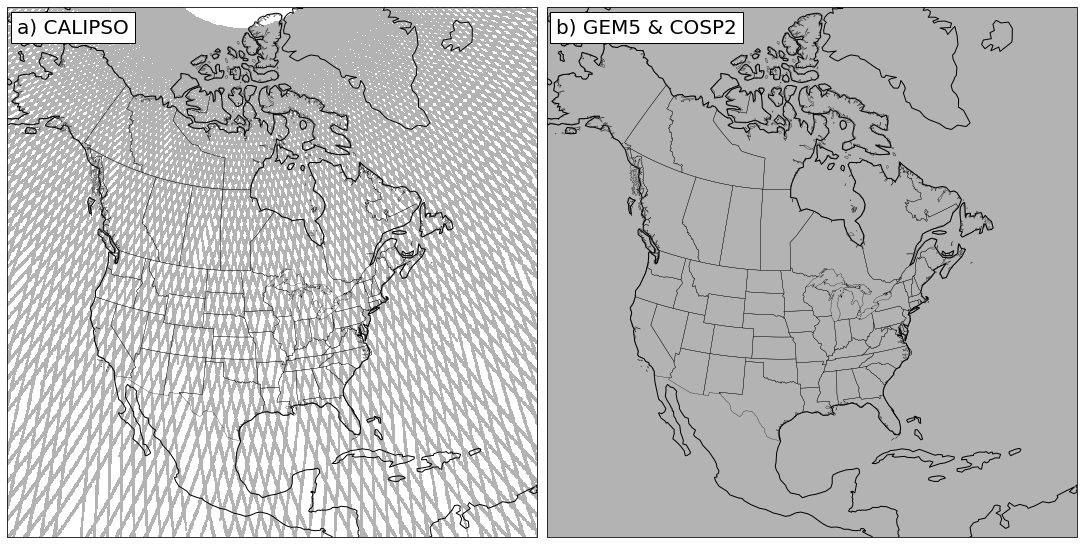

In [19]:
data_CALIPSO[0][data_CALIPSO[0] >= 0] = 0.3
data_MODIS[0][data_MODIS[0] >= 0] = 0.3

# Getting MODIS grid
nc_MODIS_template = '/pampa/poitras/DATA/MODIS/MYD06_L2/NetCDF_LowMidHigh/NAM11/Cloud_Top_Pressure/2014/MYD06_L2_20140101_0100.nc'

#########################################################################
ds_MODIS        = netCDF4.Dataset(nc_MODIS_template, 'r')
#### Data matrices ####
data_MODIS_t    = np.array(ds_MODIS['Tot_cloud_cover'][:])
### Mask MODIS matrices ####
data_MODIS_t[data_MODIS_t >= 0] = 0.3
#mask_MODIS_t_1    = np.where(data_MODIS_t > 0, 0, 1)
###################################################################
fig = plt.figure(figsize=(10,8), constrained_layout = True)

x1 = -0.3 ; x2 = 0.45; y1 = 0.939
w = 0.92; h = 0.92
ax1 = plt.axes([x1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax1.pcolormesh(lon, lat,data_CALIPSO[0], cmap='binary',vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

ax2 = plt.axes([x2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,data_MODIS_t, cmap='binary',vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm)

ax1.annotate( 'a) CALIPSO', xy=(x1 + 0.316, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b) GEM5 & COSP2'  , xy=(x2 + 0.063, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

plt.tight_layout()
plt.show()